In [1]:
import pandas as pd 
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")



from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

from subprocess import check_output
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from pandas import DataFrame

In [2]:
#importing the data 
df_actual = pd.read_csv('UTMSBA_ACTL.csv')
df_fuel = pd.read_csv('UTMSBA_FUELPRICE.csv')
df_clusters = pd.read_csv('Mean Clusts_Agg.csv')

In [4]:
df_fuel = df_fuel.rename(columns={'Hashed_Station': 'Orig', 'Date':'Dep_dt'})

In [5]:
# merge to get the fuel information
df1 = pd.merge(df_actual, df_fuel, on = ['Orig', 'Dep_dt'], how = 'inner')

In [6]:
# merge to get the clusters
df1 = pd.merge(df1, df_clusters[['Orig', 'cluster', 'cluster_euclid', 'cluster_cosine']], 
               on = 'Orig', how = 'inner')

In [94]:
df1.head()

,Dep_dt,Orig,Dest,Tail,Stage_length,ACTL_TM_IN_CENT,ACTL_TM_OUT_CENT,ACFT,Actl_BM,Gross_gal,...,mapping,cluster_euclid,cluster_cosine,pairs,year_month,top_50,hour_out,hour_in,month,day_of_week
0,2017-09-01,27,139,78,240,1005,844,1,81,536.3,...,4,3,0,820,0,0,8,10,8,4
1,2017-09-01,27,140,189,430,1151,1036,1,75,653.2,...,4,3,0,821,0,0,10,11,8,4
2,2017-09-01,27,39,50,396,2054,1943,1,71,850.2,...,4,3,0,805,0,0,19,20,8,4
3,2017-09-01,27,139,50,240,2432,2331,1,61,1223.7,...,4,3,0,820,0,0,23,24,8,4
4,2017-09-01,27,85,153,359,1728,1622,1,66,1118.8,...,4,3,0,815,0,0,16,17,8,4


## Feature Engineering

In [8]:
df1['pairs'] = df1['Orig'] + ' - ' + df1['Dest']

In [9]:
def year_month(value):
    value = str(value)
    return str(value[:7])

df1['year_month'] = df1['Dep_dt'].map(year_month)

In [10]:
import datetime

def date_format(value):
    value = str(value)
    year = int(value[:4])
    month = int(value[5:7])
    day = int(value[8:])
    
    #print(year,month,day)
    date = datetime.date(year,month, day)
    return date 


df1['Dep_dt'] = df1['Dep_dt'].map(date_format)

In [11]:
a_list = df1['pairs'].value_counts().index[:51]
def top_stations(value): 
    if value in a_list: 
        return 1 
    return 0 

df1['top_50'] = df1['pairs'].map(top_stations)
top_sta = df1[df1['top_50'] == 1]

In [12]:
def hour_of_the_day(time):
    time = str(time)
    return int(time[:-2])

df1['hour_out'] = df1['ACTL_TM_OUT_CENT'].map(hour_of_the_day)
df1['hour_in'] = df1['ACTL_TM_IN_CENT'].map(hour_of_the_day)

In [13]:
def month(value): 
    return value[-2:]

df1['month'] = df1['year_month'].map(month)

In [ ]:
df1_arima = pd.pivot_table(df1,index = 'Orig', columns = ['year_month'], aggfunc = sum, values = ['Gross_gal'])

In [14]:
from datetime import datetime as dt
df1['day_of_week'] = df1['Dep_dt'].apply(lambda x: dt.weekday(x))

In [16]:
df1['Dep_dt']= pd.to_datetime(df1['Dep_dt'])

In [17]:
df1 = df1.rename(columns={'cluster': 'mapping'})

In [ ]:
df1.columns

In [18]:
cat_columns = df1.dtypes[df1.dtypes == 'object'].index

In [ ]:
df1.head()

## AdaBoost

In [21]:
label_encoder = preprocessing.LabelEncoder()

for col in cat_columns:
    df1[col].fillna("unknown")
    df1[col] = label_encoder.fit_transform(df1[col].astype(str))

### Cluster 1

In [78]:
clus1 = df1[(df1['mapping'] == 1) ]# |(df1['mapping'] == 2) ]
clus1 = clus1[clus1.Gross_gal.between(clus1.Gross_gal.quantile(.000), clus1.Gross_gal.quantile(.95))] # without outliers

X = clus1.drop(['Dep_dt','Gross_gal', 'Enroute_gal','Alt_gal', 'Cont_gal', 'Tanker_gal', 'pairs','ACTL_TM_IN_CENT',
       'ACTL_TM_OUT_CENT','Actl_BM', 'cluster_euclid', 'cluster_cosine'], axis=1)
y = clus1.Gross_gal
feature_names = X.columns.tolist()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [24]:
X_train.head()

,Orig,Dest,Tail,Stage_length,ACFT,Hashed_Fuel_Price,mapping,year_month,top_50,hour_out,hour_in,month,day_of_week
1285625,54,113,171,1076,1,2.0453,1,6,0,8,11,2,1
1281679,54,76,294,1724,1,2.1321,1,26,0,6,9,10,6
1268491,54,21,534,1178,0,2.4742,1,14,0,11,14,10,0
3175912,34,61,464,173,0,2.1179,1,22,0,13,13,6,0
3077782,94,76,145,1546,0,2.0341,1,23,0,4,8,7,0


In [85]:
# create a function which finds the best parameters to use in the model
def best_parameters(x_train,y_train):
    
    param_dist = {
     'n_estimators': [50, 100],
     'learning_rate' : [0.01, 0.05,0.1,0.3,1],
     'loss' : ['square']
     }

    pre_gs_inst = GridSearchCV(AdaBoostRegressor(),param_grid = param_dist, scoring = 'neg_mean_squared_error')
    pre_gs_inst.fit(X_train, y_train)              
    return pre_gs_inst.best_params_

In [68]:
# split the data and find the best parameters for cluster1
params_cluster1 = best_parameters(X_train,y_train)

In [69]:
params_cluster1

{'learning_rate': 0.01, 'loss': 'square', 'n_estimators': 50}

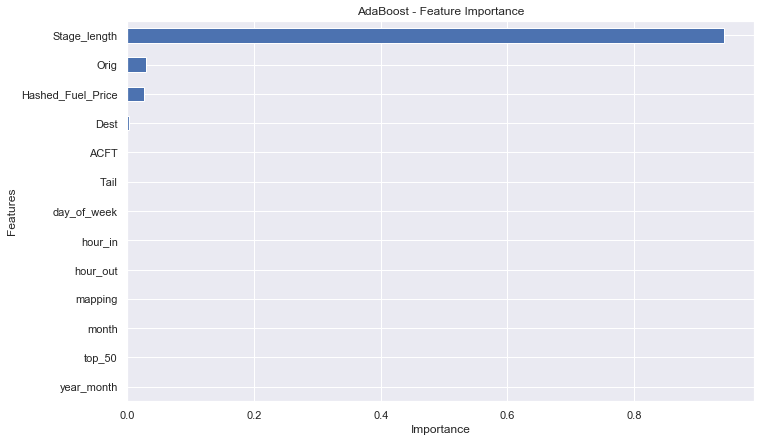

In [79]:
ada2=AdaBoostRegressor(n_estimators=50,learning_rate=0.01,random_state=1, loss = 'square')
ada2.fit(X_train, y_train)
pred = ada2.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, pred))

fea_imp = pd.DataFrame({'imp': ada2.feature_importances_, 'col': X_valid.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('AdaBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

In [80]:
a = DataFrame(pred)
a['y_valid'] = y_valid.reset_index()['Gross_gal']

a['prediction'] = a[0]
a.drop([0], axis = 1, inplace = True)
X_valid.reset_index(inplace = True)
valid = pd.concat([X_valid, a], axis=1)
gb = valid.groupby(['year_month']).sum()
gb['diff'] = abs(gb['y_valid'] - gb['prediction'])
gb_new = gb.sort_values(by = ['year_month'])
gb_new['percent_off'] = gb_new['diff'] / gb['y_valid']
gb_new.head()

,index,Orig,Dest,Tail,Stage_length,ACFT,Hashed_Fuel_Price,mapping,top_50,hour_out,hour_in,month,day_of_week,y_valid,prediction,diff,percent_off
year_month,,,,,,,,,,,,,,,,,
0,1373461008,36206,43075,218234,657927,440,1184.3734,579,0,6893,8581,4632,1684,1206311.6,1.288617e+06,82305.822994,0.068229
1,1489174962,37716,43956,231371,692638,442,1200.0895,621,0,7182,8964,5589,1835,1337100.0,1.347633e+06,10533.063466,0.007878
2,1871878053,44139,53279,296041,845719,553,1533.8901,759,0,9014,11233,7590,2249,1537375.1,1.629248e+06,91873.087044,0.059760
3,1766603915,41602,48194,269006,809927,530,1543.1943,716,0,8609,10827,7876,2261,1612728.5,1.544523e+06,68205.370223,0.042292
4,1722618488,41951,50028,258905,795951,558,1598.5735,699,0,8305,10402,0,1986,1540564.3,1.521029e+06,19534.997184,0.012680


In [81]:
gb_new['percent_off'].mean()

0.0420391984281435

## Cluster 2

In [86]:
clus2 = df1[(df1['mapping'] == 2) ]# |(df1['mapping'] == 2) ]
clus2 = clus2[clus2.Gross_gal.between(clus2.Gross_gal.quantile(.000), clus2.Gross_gal.quantile(.95))] # without outliers

X = clus2.drop(['Dep_dt','Gross_gal', 'Enroute_gal','Alt_gal', 'Cont_gal', 'Tanker_gal', 'pairs','ACTL_TM_IN_CENT',
       'ACTL_TM_OUT_CENT','Actl_BM', 'cluster_euclid', 'cluster_cosine'], axis=1)
y = clus2.Gross_gal
feature_names = X.columns.tolist()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [87]:
params_cluster2 = best_parameters(X_train,y_train)
params_cluster2

{'learning_rate': 0.01, 'loss': 'square', 'n_estimators': 100}

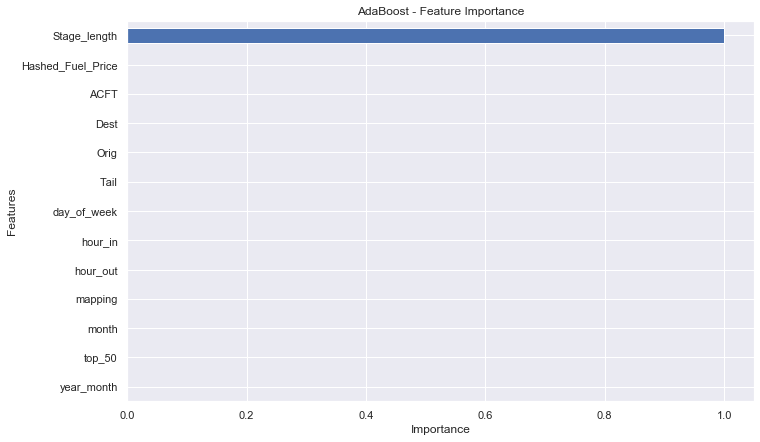

In [88]:
ada2=AdaBoostRegressor(n_estimators=100,learning_rate=0.01,random_state=1)
ada2.fit(X_train, y_train)
pred = ada2.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, pred))

fea_imp = pd.DataFrame({'imp': ada2.feature_importances_, 'col': X_valid.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('AdaBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

In [89]:
a2 = DataFrame(pred)
a2['y_valid'] = y_valid.reset_index()['Gross_gal']

a2['prediction'] = a2[0]
a2.drop([0], axis = 1, inplace = True)
X_valid.reset_index(inplace = True)
valid2 = pd.concat([X_valid, a2], axis=1)
gb2 = valid2.groupby(['year_month']).sum()
gb2['diff'] = abs(gb2['y_valid'] - gb2['prediction'])
gb_new2 = gb2.sort_values(by = ['year_month'])
gb_new2['percent_off'] = gb_new2['diff'] / gb2['y_valid']
gb_new2.head()

,index,Orig,Dest,Tail,Stage_length,ACFT,Hashed_Fuel_Price,mapping,top_50,hour_out,hour_in,month,day_of_week,y_valid,prediction,diff,percent_off
year_month,,,,,,,,,,,,,,,,,
0,13464191484,560528,652348,3332316,7101433,6949,17149.2752,17520,1294,117450,135387,70080,26504,15255082.4,1.528069e+07,25611.572555,0.001679
1,15909097567,640951,763579,3861117,8083293,7973,19122.8194,20312,1468,135996,156527,91404,29122,17981996.3,1.752715e+07,454847.507886,0.025295
2,16501546247,651064,763995,3950715,8323088,8260,20112.2221,20770,1489,138228,159566,103850,30289,18312418.0,1.796598e+07,346441.646360,0.018918
3,17188050192,666584,792029,4110287,8815340,8419,21842.7453,21522,1464,144338,167065,118371,33588,18987810.7,1.883109e+07,156716.235510,0.008254
4,16676564862,655315,770403,4009907,8570814,8213,23014.9110,21012,1567,140133,162395,0,28731,18556368.9,1.832254e+07,233827.049587,0.012601


In [90]:
gb_new2['percent_off'].mean()

0.013894923978679212

### Cluster 3

In [92]:
clus3 = df1[(df1['mapping'] == 3)]
clus3.head()

,Dep_dt,Orig,Dest,Tail,Stage_length,ACTL_TM_IN_CENT,ACTL_TM_OUT_CENT,ACFT,Actl_BM,Gross_gal,...,mapping,cluster_euclid,cluster_cosine,pairs,year_month,top_50,hour_out,hour_in,month,day_of_week


In [91]:
clus3 = df1[(df1['mapping'] == 3)]# |(df1['mapping'] == 2) ]
clus3 = clus3[clus3.Gross_gal.between(clus3.Gross_gal.quantile(.000), clus3.Gross_gal.quantile(.95))] # without outliers

X = clus3.drop(['Dep_dt','Gross_gal', 'Enroute_gal','Alt_gal', 'Cont_gal', 'Tanker_gal', 'pairs','ACTL_TM_IN_CENT',
       'ACTL_TM_OUT_CENT','Actl_BM', 'cluster_euclid', 'cluster_cosine'], axis=1)
y = clus3.Gross_gal
feature_names = X.columns.tolist()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=42)

ValueError: With n_samples=0, test_size=0.25 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
params_cluster3 = best_parameters(X_train,y_train)
params_cluster3

In [ ]:
ada2=AdaBoostRegressor(n_estimators=100,learning_rate=0.01,random_state=1)
ada2.fit(X_train, y_train)
pred = ada2.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, pred))

fea_imp = pd.DataFrame({'imp': ada2.feature_importances_, 'col': X_train.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('AdaBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

In [ ]:
a3 = DataFrame(pred)
a3['y_valid'] = y_valid.reset_index()['Gross_gal']

a3['prediction'] = a3[0]
a3.drop([0], axis = 1, inplace = True)
X_valid.reset_index(inplace = True)
valid3 = pd.concat([X_valid, a3], axis=1)
gb3 = valid3.groupby(['year_month']).sum()
gb3['diff'] = abs(gb3['y_valid'] - gb3['prediction'])
gb_new3 = gb3.sort_values(by = ['year_month'])
gb_new3['percent_off'] = gb_new3['diff'] / gb3['y_valid']
gb_new3.head()

### Cluster 4

In [99]:
clus4 = df1[(df1['mapping'] == 4) ]# |(df1['mapping'] == 2) ]
clus4 = clus4[clus4.Gross_gal.between(clus4.Gross_gal.quantile(.000), clus4.Gross_gal.quantile(.95))] # without outliers

X = clus4.drop(['Dep_dt','Gross_gal', 'Enroute_gal','Alt_gal', 'Cont_gal', 'Tanker_gal', 'pairs','ACTL_TM_IN_CENT',
       'ACTL_TM_OUT_CENT','Actl_BM', 'cluster_euclid', 'cluster_cosine'], axis=1)
y = clus4.Gross_gal
feature_names = X.columns.tolist()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [96]:
params_cluster4 = best_parameters(X_train,y_train)
params_cluster4

{'learning_rate': 0.01, 'loss': 'square', 'n_estimators': 100}

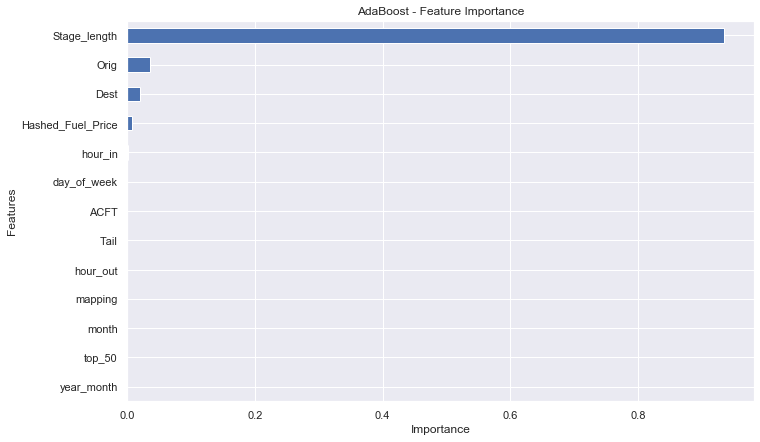

In [100]:
ada2=AdaBoostRegressor(n_estimators=100,learning_rate=0.01,random_state=1)
ada2.fit(X_train, y_train)
pred = ada2.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, pred))

fea_imp = pd.DataFrame({'imp': ada2.feature_importances_, 'col': X_valid.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('AdaBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

In [101]:
a4 = DataFrame(pred)
a4['y_valid'] = y_valid.reset_index()['Gross_gal']

a4['prediction'] = a4[0]
a4.drop([0], axis = 1, inplace = True)
X_valid.reset_index(inplace = True)
valid4 = pd.concat([X_valid, a4], axis=1)
gb4 = valid4.groupby(['year_month']).sum()
gb4['diff'] = abs(gb4['y_valid'] - gb4['prediction'])
gb_new4 = gb4.sort_values(by = ['year_month'])
gb_new4['percent_off'] = gb_new4['diff'] / gb4['y_valid']
gb_new4.head()

,index,Orig,Dest,Tail,Stage_length,ACFT,Hashed_Fuel_Price,mapping,top_50,hour_out,hour_in,month,day_of_week,y_valid,prediction,diff,percent_off
year_month,,,,,,,,,,,,,,,,,
0,5881153533,134540,239588,1162052,1720878,2825,6459.8020,12240,237,42232,47037,24480,9088,3062638.2,2.966359e+06,96278.790443,0.031437
1,6699369108,155300,269988,1304251,1921726,3139,7045.2197,13692,295,46489,51854,30807,9729,3352922.1,3.316076e+06,36845.859735,0.010989
2,6634872919,152141,258223,1255902,1895795,3040,7060.7598,13296,268,45997,51148,33240,9622,3146389.2,3.233739e+06,87349.841762,0.027762
3,6542172912,152420,254531,1266033,1887758,3066,7312.5414,13304,263,46279,51525,36586,10138,3180928.0,3.234790e+06,53861.871240,0.016933
4,6471119714,150305,259525,1243775,1824770,2961,7795.3739,13092,279,44233,49374,0,8761,3110808.2,3.145638e+06,34829.838816,0.011196


In [102]:
gb_new4['percent_off'].mean()

0.04700666371074179

### Cluster 5

In [103]:
clus5 = df1[(df1['mapping'] == 5) ]# |(df1['mapping'] == 2) ]
clus5 = clus5[clus5.Gross_gal.between(clus5.Gross_gal.quantile(.000), clus5.Gross_gal.quantile(.95))] # without outliers

X = clus5.drop(['Dep_dt','Gross_gal', 'Enroute_gal','Alt_gal', 'Cont_gal', 'Tanker_gal', 'pairs','ACTL_TM_IN_CENT',
       'ACTL_TM_OUT_CENT','Actl_BM', 'cluster_euclid', 'cluster_cosine'], axis=1)
y = clus5.Gross_gal
feature_names = X.columns.tolist()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [104]:
params_cluster5 = best_parameters(X_train,y_train)
params_cluster5

{'learning_rate': 0.01, 'loss': 'square', 'n_estimators': 50}

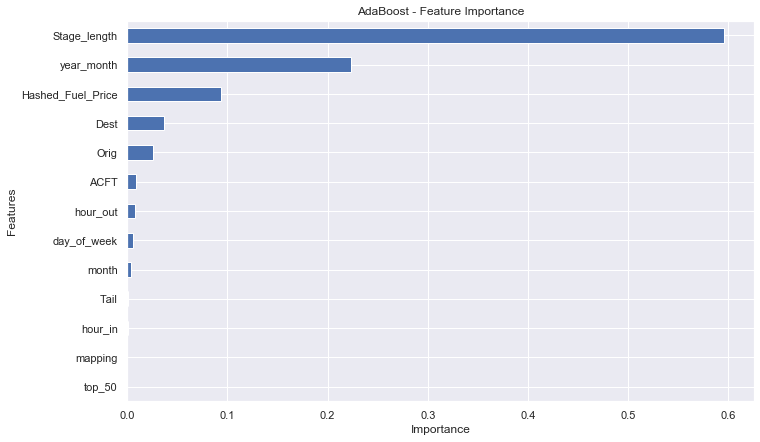

In [105]:
ada2=AdaBoostRegressor(n_estimators=50,learning_rate=0.01,random_state=1)
ada2.fit(X_train, y_train)
pred = ada2.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, pred))

fea_imp = pd.DataFrame({'imp': ada2.feature_importances_, 'col': X_valid.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('AdaBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

In [107]:
a5 = DataFrame(pred)
a5['y_valid'] = y_valid.reset_index()['Gross_gal']

a5['prediction'] = a5[0]
a5.drop([0], axis = 1, inplace = True)
X_valid.reset_index(inplace = True)
valid5 = pd.concat([X_valid, a5], axis=1)
gb5 = valid5.groupby(['year_month']).sum()
gb5['diff'] = abs(gb5['y_valid'] - gb5['prediction'])
gb_new5 = gb5.sort_values(by = ['year_month'])
gb_new5['percent_off'] = gb_new5['diff'] / gb5['y_valid']
gb_new5.head()

,index,Orig,Dest,Tail,Stage_length,ACFT,Hashed_Fuel_Price,mapping,top_50,hour_out,hour_in,month,day_of_week,y_valid,prediction,diff,percent_off
year_month,,,,,,,,,,,,,,,,,
0,200874396,3612,4829,26884,18317,48,148.4446,320,0,826,893,512,177,26182.5,19636.433555,6546.066445,0.250017
1,357934204,6153,8440,42583,30335,89,242.9520,570,0,1398,1513,1026,286,28548.7,36425.884532,7877.184532,0.275921
2,288406378,5142,6489,35631,25813,72,199.4434,460,0,1206,1300,920,288,26688.4,29384.029866,2695.629866,0.101004
3,270326656,4671,6156,35224,24113,64,196.3691,430,0,1132,1226,946,273,29206.9,27460.994696,1745.905304,0.059777
4,310951401,5679,7297,34835,26693,74,241.5198,495,0,1257,1364,0,278,24113.5,27389.783274,3276.283274,0.135869


In [108]:
gb_new5['percent_off'].mean()

0.222578318338625

### Cluster 6

In [109]:
clus6 = df1[(df1['mapping'] == 6) ]# |(df1['mapping'] == 2) ]
clus6 = clus6[clus6.Gross_gal.between(clus6.Gross_gal.quantile(.000), clus6.Gross_gal.quantile(.95))] # without outliers

X = clus6.drop(['Dep_dt','Gross_gal', 'Enroute_gal','Alt_gal', 'Cont_gal', 'Tanker_gal', 'pairs','ACTL_TM_IN_CENT',
       'ACTL_TM_OUT_CENT','Actl_BM', 'cluster_euclid', 'cluster_cosine'], axis=1)
y = clus6.Gross_gal
feature_names = X.columns.tolist()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [110]:
params_cluster6 = best_parameters(X_train,y_train)
params_cluster6

{'learning_rate': 0.01, 'loss': 'square', 'n_estimators': 50}

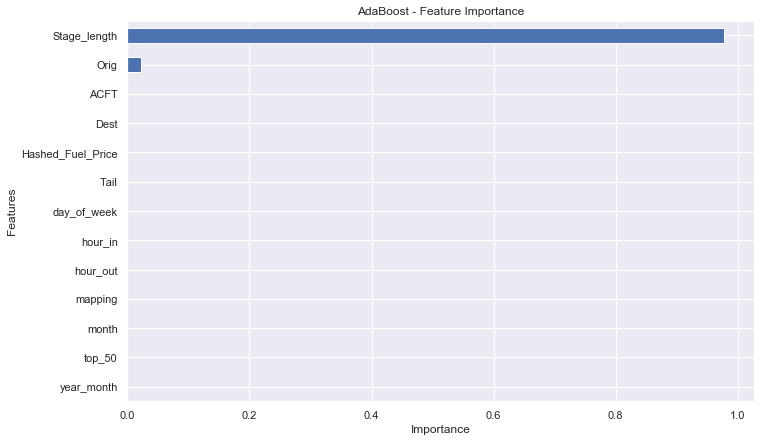

In [111]:
ada2=AdaBoostRegressor(n_estimators=50,learning_rate=0.01,random_state=1)
ada2.fit(X_train, y_train)
pred = ada2.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, pred))

fea_imp = pd.DataFrame({'imp': ada2.feature_importances_, 'col': X_valid.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('AdaBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

In [112]:
a6 = DataFrame(pred)
a6['y_valid'] = y_valid.reset_index()['Gross_gal']

a6['prediction'] = a6[0]
a6.drop([0], axis = 1, inplace = True)
X_valid.reset_index(inplace = True)
valid6 = pd.concat([X_valid, a6], axis=1)
gb6 = valid6.groupby(['year_month']).sum()
gb6['diff'] = abs(gb6['y_valid'] - gb6['prediction'])
gb_new6 = gb6.sort_values(by = ['year_month'])
gb_new6['percent_off'] = gb_new6['diff'] / gb6['y_valid']
gb_new6.head()

,index,Orig,Dest,Tail,Stage_length,ACFT,Hashed_Fuel_Price,mapping,top_50,hour_out,hour_in,month,day_of_week,y_valid,prediction,diff,percent_off
year_month,,,,,,,,,,,,,,,,,
0,12473169834,464576,733763,3695314,7441612,7723,21028.3647,58620,1325,135830,154900,78160,29203,12417758.9,1.273922e+07,3.214652e+05,0.025888
1,14157275838,521159,829088,4179653,8180688,8886,22896.3455,66252,1530,151869,173065,99378,31469,13759598.9,1.415949e+07,3.998959e+05,0.029063
2,13537728552,497659,795554,4059668,8069202,8619,22853.5202,64002,1371,147872,168460,106670,30880,13148937.2,1.388952e+07,7.405867e+05,0.056323
3,13790710310,503946,802897,4114179,8107471,8624,23893.7248,64620,1350,149933,170861,118470,33362,13283657.4,1.401472e+07,7.310659e+05,0.055035
4,13564024211,497632,786799,4064868,8075879,8351,25615.5015,64050,1415,147835,168833,0,28412,12771929.9,1.390720e+07,1.135269e+06,0.088888


In [115]:
gb_new6['percent_off'].mean()

0.02841073094246054